<a href="https://colab.research.google.com/github/Rish-23072005/ML-PROJECT-1/blob/main/Toxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Loading Dataset

In [4]:
import zipfile
import pandas as pd


with zipfile.ZipFile('/content/Toxic Comment Classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/temp1')  # Extract to a temporary directory


with zipfile.ZipFile('/content/temp1/Toxic Comment Classification/test.csv.zip', 'r') as zip_ref2:
    zip_ref2.extractall('/content/temp1/Toxic Comment Classification/test_csv_contents')

df1 = pd.read_csv('/content/temp1/Toxic Comment Classification/test_csv_contents/test.csv')  # Adjusted file path


with zipfile.ZipFile('/content/Youtube toxic comment.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/temp2')

df2 = pd.read_csv('/content/temp2/youtoxic_english_1000.csv')



#Combining Both Dataset

In [5]:
# Process df1
df1['Toxic'] = df1.iloc[:, 2:].any(axis=1)
df1_processed = df1[['comment_text', 'Toxic']].rename(columns={'comment_text': 'Text'})

# Process df2
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1)
df2_processed = df2[['Text', 'Toxic']]

# Combine df1_processed and df2_processed
df = pd.concat([df1_processed, df2_processed], ignore_index=True)

# Display the first few rows of final_df
print(df.head())

                                                Text  Toxic
0  Yo bitch Ja Rule is more succesful then you'll...  False
1  == From RfC == \n\n The title is fine as it is...  False
2  " \n\n == Sources == \n\n * Zawe Ashton on Lap...  False
3  :If you have a look back at the source, the in...  False
4          I don't anonymously edit articles at all.  False


#Exploring Daatset


In [6]:
df.describe()
# Check data types and missing values
print(df.dtypes)
print(df.isnull().sum())
# Check for duplicate comments
duplicate_rows = df[df.duplicated(subset=['Text'], keep=False)]
print("Duplicate rows based on 'Text' column:")
print(duplicate_rows)

# Drop duplicate comments
df.drop_duplicates(subset=['Text'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(df))

# Reindex the DataFrame after dropping duplicates
df.reset_index(drop=True, inplace=True)

# Distribution of 'Toxic' column
toxic_distribution = df['Toxic'].value_counts()
print(toxic_distribution)

df.to_csv("Toxic_Comments_dataset.csv")


Text     object
Toxic      bool
dtype: object
Text     0
Toxic    0
dtype: int64
Duplicate rows based on 'Text' column:
                 Text  Toxic
153756  RUN THEM OVER   True
153806  run them over   True
153821  run them over   True
153841  run them over   True
153863  RUN THEM OVER   True
Number of rows after removing duplicates: 154161
Toxic
False    153702
True        459
Name: count, dtype: int64


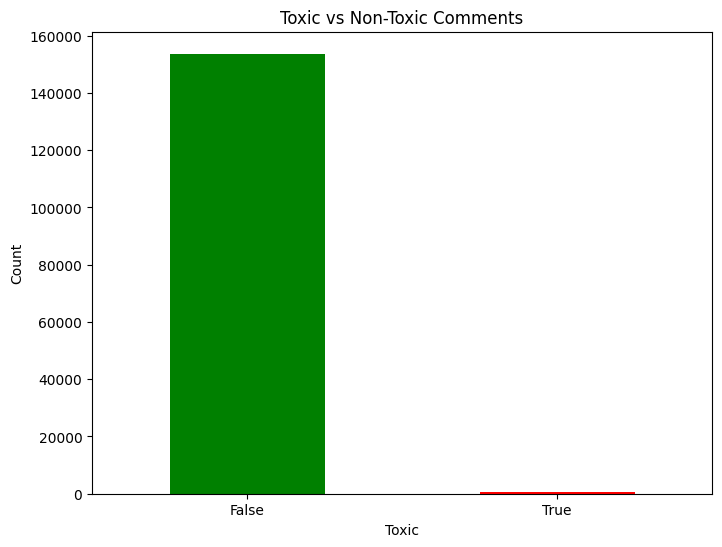

In [7]:
# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

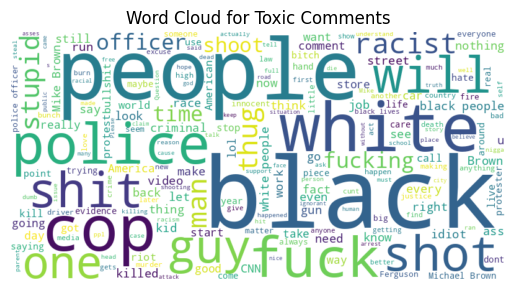

In [8]:
# Word Cloud for toxic and non-toxic comments
toxic_comments = ' '.join(df[df['Toxic']]['Text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

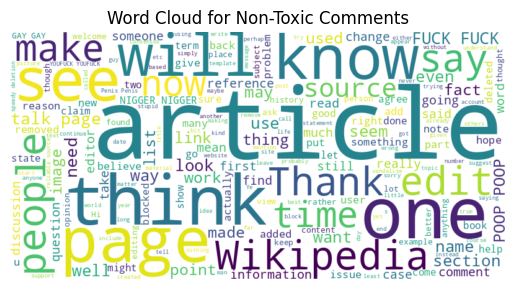

In [9]:
non_toxic_comments = ' '.join(df[~df['Toxic']]['Text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

#Data Transformation


In [10]:
# Convert True to 1 and False to 0 in the 'Toxic' column
df['Toxic'] = df['Toxic'].astype(int)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
# clean the comment_text in train_df
df['Text'] = df['Text'].map(lambda com : clean_text(com))

#Data Vectoriser

In [11]:
# Vectorize the text data using TF-IDF
vect = TfidfVectorizer(max_features=5000, stop_words='english')
X = vect.fit_transform(df['Text'])
Y = df['Toxic']

#SMOTE stands for Synthetic Minority Over-sampling Technique. It’s a technique used in machine learning, specifically in dealing with imbalanced datasets, where one class (the minority class) is significantly underrepresented compared to another class (the majority class)


Distribution after SMOTE:
Toxic
0    153702
1    153702
Name: count, dtype: int64


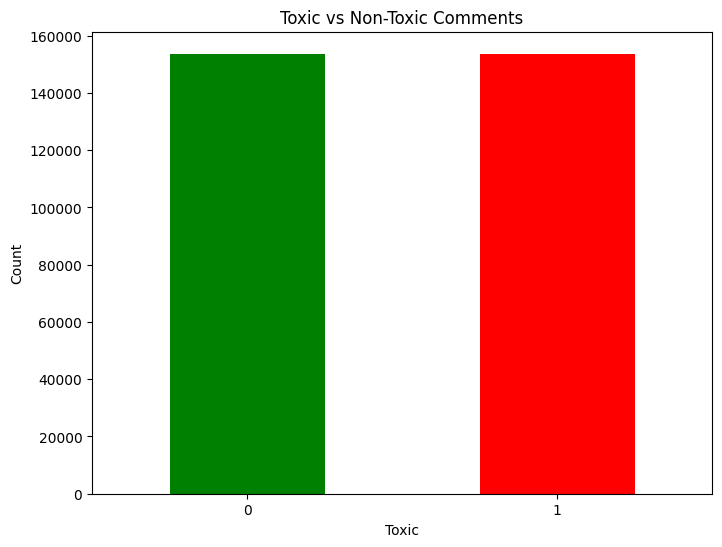

In [12]:
# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE()

# Apply SMOTE for oversampling
X_resampled, y_resampled = smote.fit_resample(X, Y)\


# Convert the oversampled data back to a DataFrame
df_resampled = pd.DataFrame(X_resampled.todense(), columns=vect.get_feature_names_out())
df_resampled['Toxic'] = y_resampled

# Check the distribution after oversampling
toxic_distribution_after = df_resampled['Toxic'].value_counts()
print("\nDistribution after SMOTE:")
print(toxic_distribution_after)

# Bar plot for toxic vs non-toxic comments
plt.figure(figsize=(8, 6))
toxic_counts = df_resampled['Toxic'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [13]:
# Example resampling process (replace this with your actual resampling code)
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

# Create a sample dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.1, 0.9])

# Apply resampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Import necessary libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Split the resampled data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Build the neural network model with Input layer
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5761 - loss: 0.7080 - val_accuracy: 0.7762 - val_loss: 0.5079
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7348 - loss: 0.5434 - val_accuracy: 0.8357 - val_loss: 0.4228
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7780 - loss: 0.4828 - val_accuracy: 0.8776 - val_loss: 0.3739
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8093 - loss: 0.4267 - val_accuracy: 0.8881 - val_loss: 0.3413
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8194 - loss: 0.3924 - val_accuracy: 0.8986 - val_loss: 0.3169
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8428 - loss: 0.3486 - val_accuracy: 0.8951 - val_loss: 0.2981
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.3303 - val_accuracy: 0.9056 - val_loss: 0.2852
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8675 - loss: 0.3215 - val_accuracy: 0.9091 - val_loss

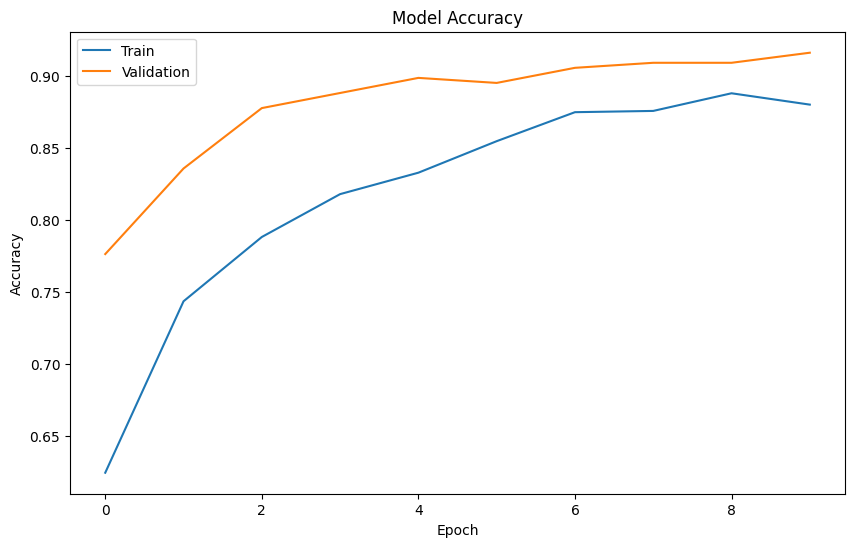

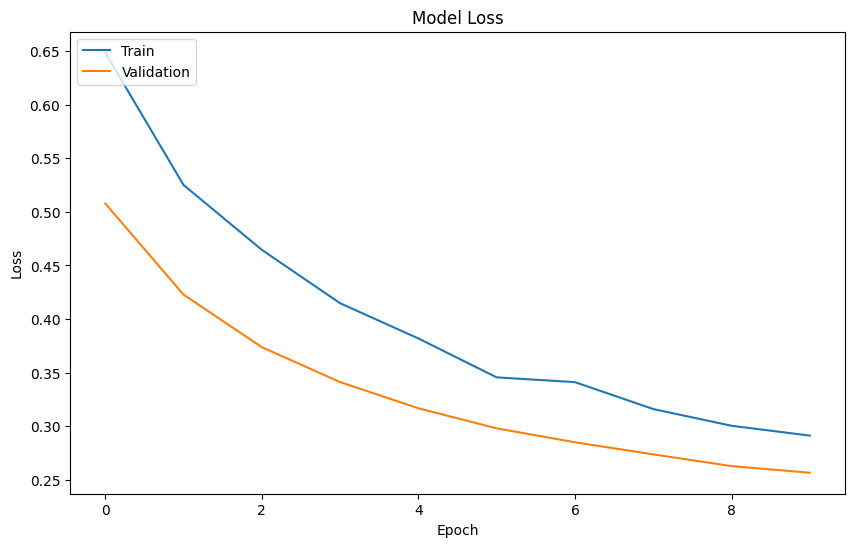

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#let’s ensure that the model is not overfitting. Moving on to model evaluation, we can confirm that the model is not overfitting.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9372 - loss: 0.2250
Test Accuracy: 0.9301676154136658
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       186
           1       0.92      0.93      0.93       172

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



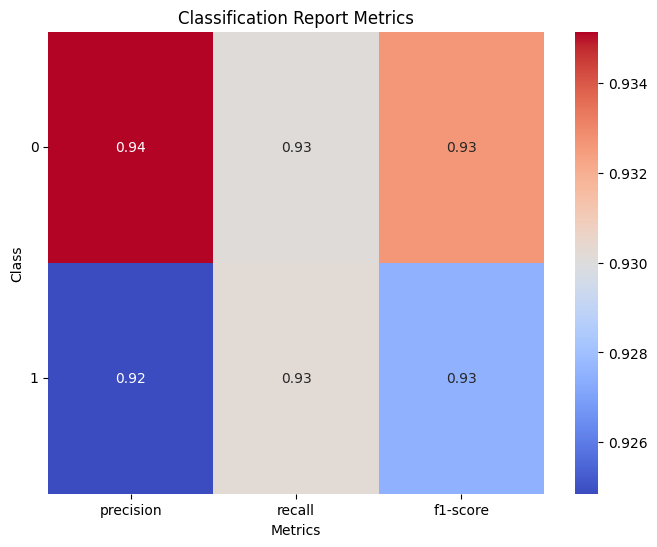

In [15]:
# Import necessary libraries
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Generate predictions on the test set
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Extract relevant metrics for visualization
class_metrics = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting the classification report metrics using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(class_metrics[['precision', 'recall', 'f1-score']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Classification Report Metrics')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.yticks(rotation=0)
plt.show()


#let’s save the vectorizer and model for further use locally

In [16]:
# Import necessary libraries
import pickle

# Assuming 'vect' is your TF-IDF vectorizer, make sure it's defined before pickling
# Example:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()  # Or load it from a file if it was previously saved

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vect, f)

# Save the Keras model
model.save('toxic_comment_model.h5')

#using saved Model and Vectorizer

In [17]:
# import pickle
# from tensorflow.keras.models import load_model
# from sklearn.feature_extraction.text import TfidfVectorizer

# class ToxicCommentClassifier:
#     def __init__(self, model_path, vectorizer_path):
#         # Load the TF-IDF Vectorizer
#         with open(vectorizer_path, 'rb') as f:
#             self.vectorizer = pickle.load(f)
#         # Load the trained model
#         self.model = load_model(model_path)

#     def classify(self, input_texts):
#         # Ensure input_texts is a list of strings
#         if not isinstance(input_texts, list):
#             raise ValueError("Input should be a list of strings.")
#         if not all(isinstance(text, str) for text in input_texts):
#             raise ValueError("All elements in the input list should be strings.")

#         # Preprocess input texts using the loaded TF-IDF Vectorizer
#         # NOTE: No need to fit the vectorizer here as it should have been fitted before saving
#         input_tfidf = self.vectorizer.transform(input_texts)

#         # Ensure the array shape is compatible with the model input
#         input_tfidf_array = input_tfidf.toarray()

#         # Predict using the loaded model
#         predictions_proba = self.model.predict(input_tfidf_array)
#         predictions = (predictions_proba > 0.5).astype(int)
#         return predictions

# # Paths to the saved model and vectorizer
# vectorizer_path = '/content/tfidf_vectorizer.pkl'
# model_path = '/content/toxic_comment_model.h5'

# # Initialize the classifier
# classifier = ToxicCommentClassifier(model_path, vectorizer_path)

# # New comments to classify
# new_comments = [
#     "I love this website, it's so helpful!",
#     "This is the worst product ever, total waste of money.",
#     "The author of this article is brilliant!",
#     "This software is a scam, do not buy it.",
#     "The customer service was excellent, very helpful and friendly.",
# ]

# # Classify the new comments
# predictions = classifier.classify(new_comments)

# # Print predictions
# for comment, prediction in zip(new_comments, predictions):
#     print(f'Comment: {comment} | Toxic: {bool(prediction[0])}')